# J(oint)-PCMCI+: Causal discovery for time series from multiple (possibly latent) contexts

TIGRAMITE is a time series analysis python module. It allows to reconstruct causal graphical models from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

This tutorial explains the Joint-PCMCI+ (J-PCMCI+) algorithm, which is implemented as the function ```J_PCMCI.run_jpcmciplus```. In contrast to the PCMCI and PCMCIplus algorithms, J-PCMCI+ is specifically designed to handle time series data from different datasets that include observations of the same variables  but that were collected in different contexts. The contexts are assumed to be represented by specific variables that are either constant across time or over the given datasets.

* * * * *
Publication on J-PCMCI+: Günther, Wiebke, and Ninad, Urmi and Runge, Jakob (2020). Causal discovery for time series from multiple datasets with latent contexts. Accepted to 39th Conference on Uncertainty in Artificial Intelligence 2023.
* * * *

The tutorial goes over the following points:
1. Motivation and basic concepts
2. The algorithm
3. Application example

In [1]:
# Imports
import numpy as np
from numpy.random import SeedSequence, default_rng
import sys
from matplotlib import pyplot as plt
from scipy import stats
import pickle
import os
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from copy import copy, deepcopy
from collections import defaultdict
import itertools

import tigramite
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.pcmci import PCMCI, _nested_to_normal
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.parcorr_mult import ParCorrMult
import tigramite.data_processing as pp
import tigramite.plotting as tp

# j_pcmciplus specific
from j_pcmci_cleaned import J_PCMCIplus
import generate_data as gd
import plot
from parcorr_mult_new import ParCorrMultNew

## 1. Motivation and basic concepts

We are interested in discovering the causal graph between variables that we have observed within different contexts, i.e., we have different datasets with observational time series of these variables (see schematic below). For instance, such contexts can be different locations at which we have observed these variables, such as time series of river runoff and local weather variables from different catchments. 

<img style="float: left; margin:10px 30px 0 0" src="./figures/intro_jpcmci.png" alt= “” width="30%" height="30%">

In this example, the local catchment systems share certain causal parents, such as time-dependent large-scale weather over all catchments, but differ in other catchment-specific but constant-in-time drivers, such as the altitude of the catchment. We call these drivers ***temporal*** and ***spatial contexts*** ($\tilde{C}_\text{time}$ and $\tilde{C}_\text{space}$ in the schematic), respectively. They differ from the system variables (runoff, local weather variables such as precipitation) in the sense that some background knowledge on their structure and on their relationship to the system variables is available. In particuar, we assume the context variables to be either constant in time or over the datasets, and, furthermore, we assume them to be exogenous to the system variables.

These assumptions allow us to overcome latent confounding that is due to unobserved context variables by pooling the datasets and considering the joint causal graph among system, context, and certain auxiliary variables as we will see in more detail in the following sections of this tutorial.



***To summarize***, in this tutorial we take a look at J-PCMCI+, which is a consistent causal discovery algorithm that can:

   1. de-confound those system nodes that are confounded by latent contexts without having any knowledge of the latent contexts themselves;
   2. retain as much information about the causal links between the observed  context and system variables as possible by checking conditional independencies appropriately;
   3. discover the correct induced causal graph between the system nodes.

### 1.1 The joint time-dependent  structural causal model

To formalize the ideas presented above, we assume that the observed data was generated by an underlying mechanism across datasets $d\in \mathcal{D}$ with $|\mathcal{D}|=M$ that can be represented by an acyclic time-dependent structural causal model (SCM) involving the time-dependent system variables $\mathbf{X}_t=\{X_t^i\}_{i\in \mathcal{I}}$ at time $t$ as well as context variables $\tilde{\mathbf{C}}=\tilde{\mathbf{C}}_{time}\dot{\cup} \ 
    \tilde{\mathbf{C}}_{space}$ with temporal contexts $\tilde{\mathbf{C}}_{time,t}=\{\tilde{C}_t^k\}_{k\in \mathcal{K}_{\rm time}}$ and (time-independent) spatial-contexts $\tilde{\mathbf{C}}_{space}=\{\tilde{C}^l\}_{l\in \mathcal{K}_{\rm space}}$, for $i\in \mathcal{I}$:
    
\begin{aligned}
            &\mathbf{X}^{d}_t:= \mathbf{f}({Pa}_X(\mathbf{X}^{d}_t),\operatorname{Pa}_{\tilde{C}_{\rm time}}(\mathbf{X}^{d}_t), \operatorname{Pa}_{\tilde{C}_{\rm space}}(\mathbf{X}^{d}_t), \boldsymbol{\eta}^{d}_t) \\ 
            &\mathbf{\tilde{C}}_{{\rm time}, t} := \mathbf{g}({Pa}_{\tilde{C}_{\rm time}}(\mathbf{\tilde{C}}_{{\rm time}, t}), \boldsymbol{\eta}_{{\rm time}, t}) \\
            &\mathbf{\tilde{C}}^{d}_{\rm space} := \mathbf{h}({Pa}{\tilde{C}_{\rm space}}(\mathbf{\tilde{C}}_{\rm space}), \boldsymbol{\eta}_{\rm space}^{d})
\end{aligned}
    where the exogenous noise variables $(\boldsymbol{\eta}^{d}_t, \boldsymbol{\eta}_{{\rm time}, t}, \boldsymbol{\eta}_{\rm space}^{d})$ are jointly independent and $\eta^{i,d}_{t}$ are identically distributed across time and space, $\eta^k_{{\rm time},t}$ are identically distributed across time, and $\eta^{l,d}_{\rm space}$ are identically distributed across space. $\operatorname{Pa}_X$ denotes the causal parents within $\mathbf{X}$, and analogously for $\operatorname{Pa}_{\tilde{C}_{\rm time}}$ and $\operatorname{Pa}_{\tilde{C}_{\rm space}}$.
    
Note that we assume that the context variables are exogeneous to the system. In other words, system variables cannt be parents of context variables.


### 1.2 Context variables and dummy variables

Let us take a closer look at the context variables $\tilde{\mathbf{C}}_\text{time}$ and $\tilde{\mathbf{C}}_\text{space}$ in the SCM above. 

A temporal context variable $C^i_\text{time} \in \tilde{\mathbf{C}}_\text{time}$ is a time-dependent random variable that remains the same across datasets. A spatial context variable $C^i_\text{space} \in \tilde{\mathbf{C}}_\text{space}$ is a random variable that is constant over time and within a dataset but can change across datasets. In our motivational example,$C^i_\text{time}$ could represent large-scale weather dynamics that affect multiple observational sites at once. Another example could be the economic development in a country over a time that affects all individuals living in that country. An example for $C^i_\text{space}$ could be the average slope in a river catchment or the height of an individual. 
We think of the context variables as corresponding to real-world phenomena.

However, J-PCMCI+ can also deal with unobserved context variables. This is achieved through auxiliary variables, so-called dummies that mimic the structure of context variables. These dummy variables label each time-step or dataset, respectively (and thus the time dummy has a unique value for each time step, and the space dummy has a unique value within each dataset). Generally, their values can not be interpreted as a physical quantity. In that sense, the dummy variable is not a causal variable itself. They are intended to be a placeholder for the unobserved context variables, in order to capture confounding between system variables due to latent context variables. 

Within J-PCMCI+, the dummy variables are encoded using one-hot vectors, i.e., for the time dummy the first time point has the corresponding dummy-value $(1,0,\ldots,0)^T \in \{ 0,1 \}^T$, the second time point corresponds to $(0,1,\ldots,0)^T$, and so on. For the space dummy dataset $1$ corresponds to the dummy-value $(1,0,\ldots,0)^T \in \{ 0,1 \}^M$, etc.

## 2. The algorithm

J-PCMCI+ extends the PCMCI+ time series causal discovery algorithm to the case of datasets from multiple dataset- or time dependent contexts with potentially unobserved context confounders of the system variables. It does so by combining PCMCI+ with the JCI-approach [1], i.e., pooling datasets from multiple contexts, and adding observed context variables to the graph. Furthermore, it uses time- and space-dummy variables to account for latent context variables that confound system variables, similar to [2].


The method consists of four main steps: one $\text{PC}_1$ lagged phase and three MCI phases. 

1. ***Discovery of supersets of the lagged parents of the system and observed temporal context nodes by running the $\text{PC}_1$ lagged phase on this subset of nodes.***

2. Next, the ***MCI test is run on pairs of system and context nodes conditional on subsets of system and context***, i.e. perform MCI tests for pairs $((C^j_{t-\tau}, X^i_t))_{\tau > 0}$,  $(C_t^j, X_t^i)$, $(X_t^i, C_t^j)$ for all $i,j$, 
    $$
        C_{t-\tau}^i \perp\!\!\!\!\perp X_t^j | \mathbf{S}, \hat{\mathcal{B}}^-_t(X_t^j)  \setminus \{ C_{t-\tau}^i \}, \hat{\mathcal{B}}^-_{t-\tau}(C_{t-\tau}^i)
    $$
with $\mathbf{S}$ being a subset of the contemporaneous adjacencies $\mathcal{A}_t(X_t^j)$ and $\hat{\mathcal{B}}^-_t(X_t^j)$ are the lagged adjacencies from step one. If $C$ is a spatial context variable, we only have to test the contemporaneous pairs $(C_t^j, X_t^i)$, $(X_t^i, C_t^j)$ for all $i,j$. If $C_t^j$ and $X_t^i$ are conditionally independent, all lagged links between $C_t^j$ and $X^j_{t-\tau}$ are also removed for all $\tau$.

3. ***Perform MCI tests on all system-dummy pairs conditional on the superset of lagged links, the discovered contemporaneous context adjacencies, as well as on subsets of contemporaneous system links***, i.e. test for $(D, X_t^i)$, $(X_t^i, D)$ for all $i$, i.e.\ 
    $$
    D \perp\!\!\!\!\perp X_t^j | \mathbf{S}, \hat{\mathcal{B}}^C_t(X_t^j)
    $$
    where $\mathbf{S} \subset \mathcal{A}_t(X_t^i)$ and $\hat{\mathcal{B}}^C_t(X_t^j)$ are the lagged and contextual adjacencies found in the previous step.
If $D$ and $X_t^j$ are found to be conditionally independence, links between $D$ and $X^j_{t-\tau}$ are removed for all $\tau$.
Using assumption \ref{ass:JCI}, context node is the parent in all system-context links.

4. Finally, we ***perform  MCI tests on all system pairs conditional on discovered lagged, context and dummy adjacencies, as well as on subsets of contemporaneous system links and orientation phase***. In more detail, we perform MCI test for pairs $((X^j_{t-\tau}, X_t^i))_{\tau > 0}$, $(X_t^i, X_t^j)$ for all $i, j$, i.e.
    $$
     X^i_{t-\tau} \perp\!\!\!\!\perp X_t^j | \mathbf{S}, \hat{\mathcal{B}}^{CD}_t(X_t^j)  \setminus \{ X_{t-\tau}^i \},  \hat{\mathcal{B}}^{CD}_t(X_{t-\tau}^i) 
    $$
    where $\mathbf{S} \subset \mathcal{A}_t(X_t^i)$ and $\hat{\mathcal{B}}^{CD}_t(X_t^j)$ are the lagged, contextual, and dummy adjacencies found in the previous steps.
Finally, all remaining edges (without expert knowledge) are oriented using the PCMCI$^+$ orientation phase while making use of all triples involving one context or dummy variable and two system variables as in the non-time series case.

## 3. Application Example
This section demonstrates and explains the application of J-PCMCI+ on synthetic data.

### 3.1 Setup 
Here we choose the random seed, how large of a sample we want to generate, and some other hyperparameters.

In [2]:
# Set seeds for reproducibility
ss = SeedSequence(12345)
child_seeds = ss.spawn(2)

model_seed = child_seeds[0]
context_seed = child_seeds[1]

random_state = np.random.default_rng(model_seed)

# Choose the time series length and number of spatial contexts
T=100
nb_domains = 50

transient_fraction=0.2
tau_max = 2
frac_observed = 0.5

### 3.2 Data generation
For generating synthetic data, we consider a specific version of the time-dependent SCM (1). Namely, within each dataset $d$ at time point $t$:
\begin{aligned}
X^{1,d}_t &= 0.3X^{1,d}_{t-1} + 0.6C^4_t + 0.5L^5 + \eta^{1,d}_t, \\
X^{2,d}_t &= 0.4X^{2,d}_{t-1} + 0.4C^4_{t-1} + \eta^{2,d}_t, \\
X^{3,d}_t &= 0.3X^{3,d}_{t-1} - 0.5X^{2,d}_{t-2} + 0.5L^5 + 0.6C^6 + \eta^{3,d}_t, \\
C^4_t &= \eta^4_t, \\
L^{5,d} &= \eta^{5,d}, \\
C^{6,d} &= \eta^{5,d}, \\
\end{aligned}
where $C_t^4$ has the same value within each dataset, and $L^5$ and $C^6$ are constant over time.

In [3]:
# Specify the model
def lin(x): return x

links_sys = {0: [((0, -1), 0.3, lin), ((3, -1), 0.6, lin), ((4, -1), 0.9, lin)],
         1: [((1, -1), 0.4, lin), ((3, -1), 0.4, lin)],
         2: [((2, -1), 0.3, lin), ((1, -2), -0.5, lin), ((4, -1), 0.9, lin), ((5, 0), 0.6, lin)]                                 
        }

links_tc = {3:[], 4: []}
links_sc = {5: []}

# Specify dynamical noise term distributions, here unit variance Gaussians
#random_state = np.random.RandomState(seed)
noises = [random_state.standard_normal for j in range(6)]

contextmodel = gd.ContextModel(links_tc=links_tc, links_sc=links_sc, 
                            links_sys=links_sys, noises=noises, 
                            seed=context_seed)

data_ens, nonstationary = contextmodel.generate_data(nb_domains, T, transient_fraction)

assert not nonstationary

# decide which context variables should be latent, and which are observed
observed_indices_time = [4]
latent_indices_time = [3]

observed_indices_space = [5]
latent_indices_space = []

# all system variables are also observed, thus we get the following observed data
observed_indices = list(links_sys.keys())+observed_indices_time+observed_indices_space
data_observed = deepcopy(data_ens)
data_observed = {key: data_ens[key][:,observed_indices] for key in data_ens}

We have a quick look at the ground truth graph that we now have specified and which corresponds to the SCM (1) above. For that we use the function ```tp.plot_graph```. The observed temporal and spatial context nodes are labelled as ```t-C_i``` and ```s-C_i```, respectively. Their latent counterparts are labelled as ```t-L_i``` and ```s-L_i```, respectively. 

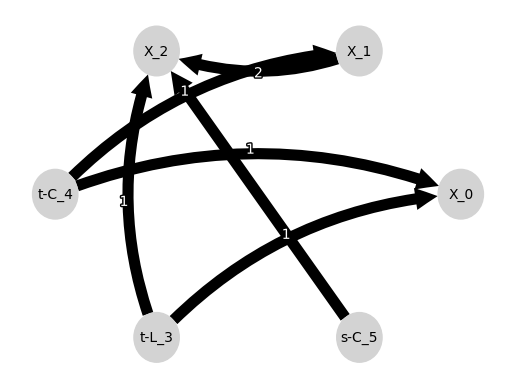

In [4]:
links = {**links_sys, **links_tc, **links_sc}
gt_graph = toys.links_to_graph(links, tau_max=tau_max)

sys_var_names = ['X_' + str(i) for i in links_sys.keys()]
temp_context_names = ['t-C_'+str(i) for i in observed_indices_time] + \
                        ['t-L_'+str(i) for i in latent_indices_time]
spatial_context_names = ['s-L_'+str(i) for i in latent_indices_space] + ['s-C_'+str(i) for i in observed_indices_space]
                            
tp.plot_graph(gt_graph, var_names=sys_var_names+temp_context_names+spatial_context_names)
plt.show()

In [5]:
# Add one-hot-encoding of time-steps and dataset index to the observational data. 
# These are the values of the time and space dummy variables.
dummy_data_time = np.identity(T)

data_dict = {}
for i in range(nb_domains):
    dummy_data_space = np.zeros((T, nb_domains))
    dummy_data_space[:,i] = 1.
    data_dict[i] = np.hstack((data_observed[i], dummy_data_time, dummy_data_space))

# Define vector-valued variables including dummy variables as well as observed (system and context) variables
nb_observed_context_nodes = len(observed_indices_time) + len(observed_indices_space)
N = len(links_sys.keys())
process_vars = list(links_sys.keys())
observed_temporal_context_nodes = list(range(N, N + len(observed_indices_time)))
observed_spatial_context_nodes = list(range(N + len(observed_indices_time), 
                                            N + len(observed_indices_time) + len(observed_indices_space)))
time_dummy_index = N + nb_observed_context_nodes
space_dummy_index = N+nb_observed_context_nodes+1
time_dummy = list(range(time_dummy_index, time_dummy_index + T))
space_dummy = list(range(time_dummy_index + T, time_dummy_index + T + nb_domains))

vector_vars = {i: [(i, 0)] for i in process_vars + observed_temporal_context_nodes + observed_spatial_context_nodes}
vector_vars[time_dummy_index] = [(i, 0) for i in time_dummy]
vector_vars[space_dummy_index] = [(i, 0) for i in space_dummy]

# Name all the variables and initialize the dataframe object
# Be careful to use analysis_mode = 'multiple'
sys_var_names = ['X_' + str(i) for i in process_vars]
context_var_names = ['t-C_'+str(i) for i in observed_indices_time] + ['s-C_'+str(i) for i in observed_indices_space]
var_names = sys_var_names + context_var_names + ['t-dummy', 's-dummy']

dataframe = pp.DataFrame(
    data=data_dict,
    vector_vars = vector_vars,
    analysis_mode = 'multiple',
    var_names = var_names
    )

Let's look at the first two datasets by plotting the time series with the function ```tp.plot_timeseries```. Note that the observed spatial context variable ```s-C_5``` is constant across time but has a different value within each dataset, and the temporal context variable ```t-C_3``` has the same values in each dataset but it varies over time. 

You can also see the one-hot encoding of the dummy variables.

In [6]:
#for dataset in [0,1]:
#    plot.plot_timeseries(selected_dataset = dataset, dataframe = dataframe, figsize=(5, 10))
#    plt.show()

### Run J-PCMCI+
We set tau_max = 2. Heuristics for choosing this hyper parameter are described in the PCMCI tutorial. There, it is also described how to choose an appropriated conditional independence test based on scatter plots. We further choose pc_alpha = 0.01 and apart from that do not modify the default hyperparameter settings.

- Parameters

In [8]:
# Create a J-PCMCI+ object, passing the dataframe and (conditional)
# independence test objects, as well as the observed temporal and spatial context nodes 
# and the indices of the dummies.
j_pcmciplus = J_PCMCIplus(dataframe=dataframe,
                      # ParCorrMultNew is a variant of ParCorrMult that can deal with data rows that are constant zero
                      cond_ind_test=ParCorrMultNew(significance='analytic'), 
                      verbosity=1, 
                      time_context_nodes=observed_temporal_context_nodes, 
                      space_context_nodes=observed_spatial_context_nodes,
                      time_dummy=time_dummy_index, 
                      space_dummy=space_dummy_index)


# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01


# Run J-PCMCI+
results = j_pcmciplus.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)


##### Discovering context-system links #####

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
link_assumptions = {0: {(0, 0): 'o?o', (0, -1): 'o?o', (0, -2): 'o?o', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): 'o?o', (0, -2): 'o?o', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): 'o?o', (0, -2): 'o?o', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 3: {(3, -1): 'o?o', (3, -2): 'o?o'}, 4: {}, 5: {}, 6: {}}
independence test = par_corr_mult
tau_min = 1
tau_max = 2
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable X_0 has 3 

#### Plotting the results
Next, we use the function ```tp.plot_graph``` to plot the learned summary DAG. In our example the learned graph exactly agrees with the true DAG. 

Note, in particular, that J-PCMCI+ has correctly identified the links between the observed context variables and the system variables. It also managed to deconfound $X^0$ and $X^2$ which are confounded by an unobserved spatial context variable ($L^4$) using the space dummy.

The edges are colored according to the test statistic values returned by ```J_PCMCI.run_jpcmci```, i.e., the maximum absolute value of ```val_matrix[i, j, tau]``` determines the color of the edge between $X^i_{t-\tau}$ and $X^j_t$ (provided this edge exists) according to the color scale at the bottom. The color of node denotes the maximum of the absolute value of ```val_matrix[i, i, tau]``` across all $1 \leq \tau \leq \tau_\text{max}$.


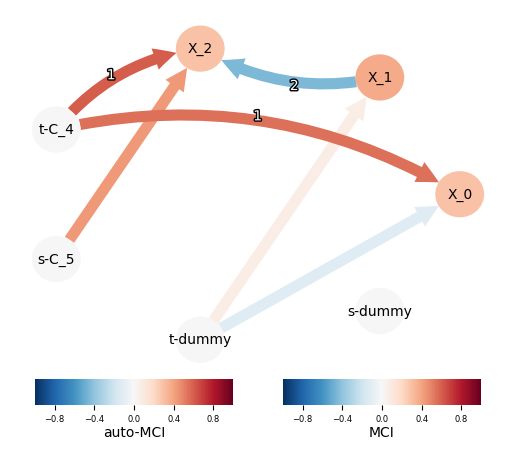

In [9]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
plt.show()

When we do not include the dummy variables, we see that $X^1$ and $X^0$ are confounded.

In [11]:
# without dummy

# Name all the variables and initialize the dataframe object
# Be careful to use analysis_mode = 'multiple'
sys_var_names = ['X_' + str(i) for i in links_sys.keys()]
context_var_names = ['t-C_'+str(i) for i in observed_indices_time] + ['s-C_'+str(i) for i in observed_indices_space]
var_names = sys_var_names + context_var_names 

dataframe = pp.DataFrame(
    data=data_observed,
    analysis_mode = 'multiple',
    var_names = var_names
    )

# Create a J-PCMCI+ object, passing the dataframe and (conditional)
# independence test objects, as well as the observed temporal and spatial context nodes 
# and the indices of the dummies.
j_pcmciplus = J_PCMCIplus(dataframe=dataframe,
                      # ParCorrMultNew is a variant of ParCorrMult that can deal with data rows that are constant zero
                      cond_ind_test=ParCorrMultNew(significance='analytic'), 
                      verbosity=1, 
                      time_context_nodes=observed_temporal_context_nodes, 
                      space_context_nodes=observed_spatial_context_nodes,
                      time_dummy=None, 
                      space_dummy=None)


# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01


# Run J-PCMCI+
results = j_pcmciplus.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)

##### Discovering context-system links #####

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
link_assumptions = {0: {(0, 0): 'o?o', (0, -1): 'o?o', (0, -2): 'o?o', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): 'o?o', (0, -2): 'o?o', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): 'o?o', (0, -2): 'o?o', (1, 0): 'o?o', (1, -1): 'o?o', (1, -2): 'o?o', (2, 0): 'o?o', (2, -1): 'o?o', (2, -2): 'o?o', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 3: {(3, -1): 'o?o', (3, -2): 'o?o'}, 4: {}}
independence test = par_corr_mult
tau_min = 1
tau_max = 2
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable X_0 has 3 link(s):
     

In [ ]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
plt.show()

#### References

- [1] Mooij
- [2] CD-NOD